In [2]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import time
import os

from sklearn.preprocessing import MinMaxScaler #to normalize data

#for deep learning

import keras
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Masking, Dropout
from keras.optimizers import RMSprop, Adam
from keras.callbacks import History
from keras import callbacks

In [3]:
# based on data wrangling python notebook

def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OptSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["Sensor"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    cols_to_drop = ['OptSet3', 'Sensor1', 'Sensor5', 'Sensor6', 
                    'Sensor10', 'Sensor14','Sensor16', 
                    'Sensor18', 'Sensor19']

    df_train = pd.read_csv('./CMaps/train_FD001.txt',sep='\s+', names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv('./CMaps/test_FD001.txt', sep='\s+', names=input_file_column_names)
    
    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)

    y_true = pd.read_csv('./CMaps/RUL_FD001.txt', sep='\s+', names=["RUL"])
    y_true["UnitNumber"] = y_true.index
    
    return df_train, df_test, y_true

In [4]:
df_train, df_test, y_true = prepare_data()
df_train.shape, df_test.shape, y_true.shape

((20631, 18), (13096, 17), (100, 2))

In [5]:
features = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])
features

Index(['OptSet1', 'OptSet2', 'Sensor2', 'Sensor3', 'Sensor4', 'Sensor7',
       'Sensor8', 'Sensor9', 'Sensor11', 'Sensor12', 'Sensor13', 'Sensor15',
       'Sensor17', 'Sensor20', 'Sensor21'],
      dtype='object')

In [6]:
## Standardization
sc = MinMaxScaler(feature_range=(-1, 1))
df_train[features] = sc.fit_transform(df_train[features])
df_test[features] = sc.transform(df_test[features])

In [7]:
df_train.head()

,UnitNumber,Cycle,OptSet1,OptSet2,Sensor2,Sensor3,Sensor4,Sensor7,Sensor8,Sensor9,Sensor11,Sensor12,Sensor13,Sensor15,Sensor17,Sensor20,Sensor21,RUL
0,1,1,-0.080460,-0.666667,-0.632530,-0.186396,-0.380486,0.452496,-0.515152,-0.780490,-0.261905,0.266525,-0.588235,-0.272028,-0.333333,0.426357,0.449323,191
1,1,2,0.218391,-0.500000,-0.433735,-0.093961,-0.294733,0.256039,-0.575758,-0.799515,-0.238095,0.530917,-0.441176,-0.177376,-0.333333,0.333333,0.462027,190
2,1,3,-0.494253,0.500000,-0.313253,-0.260955,-0.258947,0.420290,-0.454545,-0.719914,-0.500000,0.590618,-0.558824,-0.285110,-0.666667,0.255814,0.242751,189
3,1,4,0.080460,0.000000,-0.313253,-0.487683,-0.337610,0.481481,-0.363636,-0.750965,-0.666667,0.778252,-0.411765,-0.666795,-0.333333,0.147287,0.324772,188
4,1,5,-0.218391,-0.333333,-0.301205,-0.485066,-0.190749,0.336554,-0.515152,-0.700081,-0.488095,0.492537,-0.529412,-0.195845,-0.166667,0.178295,0.409003,187


In [8]:
df_test.head()

,UnitNumber,Cycle,OptSet1,OptSet2,Sensor2,Sensor3,Sensor4,Sensor7,Sensor8,Sensor9,Sensor11,Sensor12,Sensor13,Sensor15,Sensor17,Sensor20,Sensor21
0,1,1,0.264368,0.500000,0.090361,-0.378679,-0.461175,0.304348,-0.575758,-0.744773,-0.583333,0.292111,-0.558824,-0.382070,-0.333333,0.116279,0.323667
1,1,2,-0.310345,-0.500000,-0.698795,-0.240898,-0.555368,0.610306,-0.666667,-0.706632,-0.226190,0.479744,-0.470588,-0.573682,-0.166667,0.364341,0.373654
2,1,3,0.034483,0.166667,-0.246988,-0.306736,-0.355503,0.371981,-0.545455,-0.683837,-0.226190,0.398721,-0.558824,-0.082724,-0.166667,0.457364,0.442695
3,1,4,0.482759,0.000000,-0.259036,-0.429693,-0.183997,0.359098,-0.606061,-0.788567,-0.488095,0.147122,-0.500000,-0.485956,-0.500000,0.333333,0.324220
4,1,5,0.160920,0.000000,-0.216867,-0.295836,-0.335922,0.388084,-0.666667,-0.795208,-0.452381,0.475480,-0.558824,-0.398230,-0.666667,0.317829,0.432753


In [9]:
features

Index(['OptSet1', 'OptSet2', 'Sensor2', 'Sensor3', 'Sensor4', 'Sensor7',
       'Sensor8', 'Sensor9', 'Sensor11', 'Sensor12', 'Sensor13', 'Sensor15',
       'Sensor17', 'Sensor20', 'Sensor21'],
      dtype='object')

In [16]:
def train_numpy(df, sequence_length, seq_cols):
    data_array = df[seq_cols].values
    num_elements = df.shape[0]
    
    lstm_array = []
    
    # generate the sequences
    for start in range(num_elements - sequence_length + 1):
        stop = start + sequence_length
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

In [17]:
def target_numpy(df, sequence_length, label):
    data_array = df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [18]:
def test_numpy(df, sequence_length, seq_cols, mask_value):
    
    df_mask = pd.DataFrame(np.zeros((sequence_length - 1, df.shape[1])), columns=df.columns)
    df_mask[:] = mask_value
    
    id_df = pd.concat([df_mask, df], ignore_index=True)
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array = []
    
    start = num_elements - sequence_length
    stop = num_elements
    
    lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [19]:
sequence_length = 50
mask_value = 0

x_train=np.concatenate(list(list(train_numpy(df_train[df_train['UnitNumber']==unit], sequence_length, features)) 
                            for unit in df_train['UnitNumber'].unique()))
print(x_train)

[[[-0.08045977 -0.66666667 -0.63253012 ... -0.33333333  0.42635659
    0.44932339]
  [ 0.2183908  -0.5        -0.43373494 ... -0.33333333  0.33333333
    0.46202706]
  [-0.49425287  0.5        -0.31325301 ... -0.66666667  0.25581395
    0.24275062]
  ...
  [ 0.2183908   0.16666667 -0.59036145 ... -0.33333333  0.24031008
    0.30019332]
  [-0.16091954  0.83333333 -0.38554217 ... -0.33333333  0.42635659
    0.53438277]
  [-0.36781609 -0.16666667 -0.06024096 ... -0.33333333  0.10077519
    0.42612538]]

 [[ 0.2183908  -0.5        -0.43373494 ... -0.33333333  0.33333333
    0.46202706]
  [-0.49425287  0.5        -0.31325301 ... -0.66666667  0.25581395
    0.24275062]
  [ 0.08045977  0.         -0.31325301 ... -0.33333333  0.14728682
    0.32477216]
  ...
  [-0.16091954  0.83333333 -0.38554217 ... -0.33333333  0.42635659
    0.53438277]
  [-0.36781609 -0.16666667 -0.06024096 ... -0.33333333  0.10077519
    0.42612538]
  [-0.11494253  0.5        -0.03614458 ... -0.16666667  0.24031008
    0.

In [20]:
#generate target of train
y_train=np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "RUL")) 
                              for unit in df_train['UnitNumber'].unique()))
print(y_train.shape)

(15731,)


In [21]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, features, mask_value)) 
                           for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 15)


In [22]:
y_test = y_true.RUL.values
y_test.shape

(100,)

In [23]:
nb_features = x_train.shape[2]
nb_out = 1

In [24]:
nb_features

15

In [30]:
history = History()

model = Sequential()
model.add(LSTM(
         units=100,
         return_sequences=True,
         input_shape=(sequence_length, nb_features)))
model.add(Dropout(0.2))
model.add(LSTM(
          units=100,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='relu'))
model.add(Activation("relu"))
model.compile(loss="mse", optimizer="rmsprop", metrics=['mse'])

model.summary()

C:\Users\kamal\anaconda3\envs\dl\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 50, 100)             │          46,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,901 (495.71 KB)

 Trainable params: 126,901 (495.71 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1,
         callbacks = [history, keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode="auto")])

Epoch 1/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 31s 65ms/step - loss: 6694.5322 - mse: 6694.5322 - val_loss: 5551.5781 - val_mse: 5551.5781
Epoch 2/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - loss: 2851.9885 - mse: 2851.9885 - val_loss: 2592.0530 - val_mse: 2592.0530
Epoch 3/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - loss: 1273.6144 - mse: 1273.6144 - val_loss: 1540.9062 - val_mse: 1540.9062
Epoch 4/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - loss: 827.5641 - mse: 827.5641 - val_loss: 1214.5563 - val_mse: 1214.5563
Epoch 5/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - loss: 715.9861 - mse: 715.9861 - val_loss: 1099.7386 - val_mse: 1099.7386
Epoch 6/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - loss: 638.2802 - mse: 638.2802 - val_loss: 1157.6150 - val_mse: 1157.6150


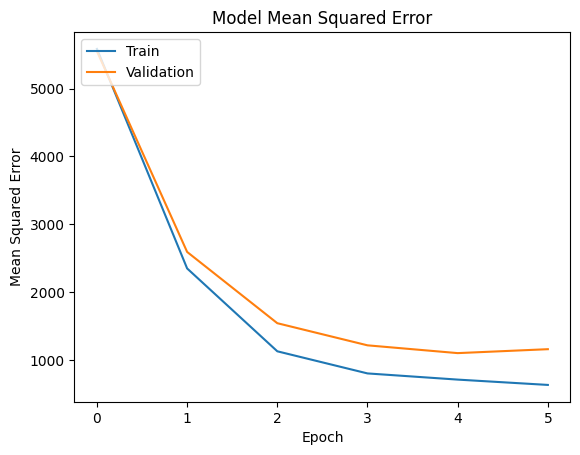

In [41]:
# Plot training & validation mean squared error values
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model Mean Squared Error')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Evaluate on Train Set

In [42]:
scores = model.evaluate(x_train, y_train, verbose=1, batch_size=200)
print('MSE: {}'.format(scores[1]))

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 459.2239 - mse: 459.2239
MSE: 602.2500610351562


### Evaluate on Test Set

In [43]:
scores_test = model.evaluate(x_test, y_test, verbose=2)
print('MSE: {}'.format(scores_test[1]))

4/4 - 0s - 20ms/step - loss: 408.6851 - mse: 408.6851
MSE: 408.68511962890625


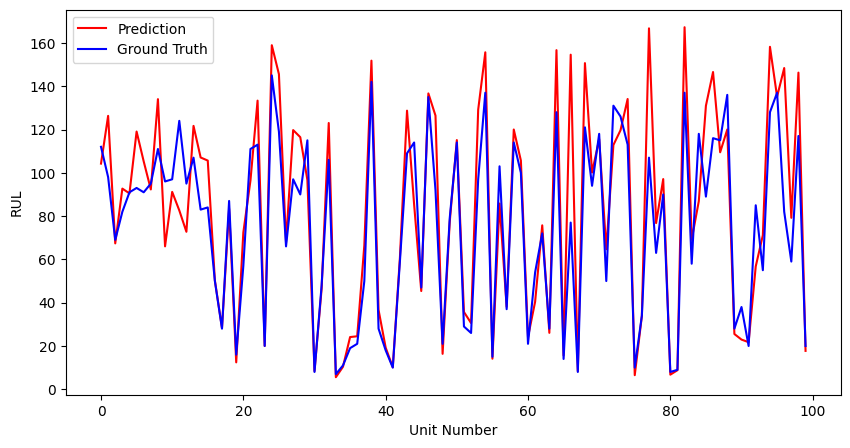

In [47]:
y_pred_test = model.predict(x_test, verbose=0)

plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.ylabel("RUL")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()